<h1><center>Machine Learning Project - AVAZU<center></h1>


In [4]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import category_encoders as ce
import time

In [5]:
import sys
from zipfile import ZipFile
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
AVAZU_URL = "https://bianchi.wp.imt.fr/files/2019/05/train-1000000.zip"
AVAZU_FILENAME = AVAZU_URL.rsplit('/', 1)[1]


if not op.exists(AVAZU_FILENAME):
    print('Downloading %s to %s...' % (AVAZU_URL, AVAZU_FILENAME))
    urlretrieve(AVAZU_URL, AVAZU_FILENAME)
    ZipFile(AVAZU_FILENAME).extractall('.')

In [6]:
ZipFile(AVAZU_FILENAME).extractall('.')

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

Data description here: https://www.kaggle.com/c/avazu-ctr-prediction/data  


In [8]:
df = pd.read_csv('train-1000000')

##Work assignment

1.   Perform Exploratory Data Analysis (EDA)
2.   Predict the probability that an add is clicked, based on the features. 
3.   Evaluate the performance of your method.

##Work evaluation

Your work will be evaluated based on:

*   The interest of the EDA (4 points)
*   The quality of the comments/remarks throughout the notebook (4 points)
*   The feature engineering (5 points)
*   The efforts made in trying several predictors and tuning them (5 points)
*   The relevance of the performance criteria used to conclude (2 points)
*   BONUS (+1pt) : Register to the AVAZU challenge in Kaggle. What is your rank?

You may find the following script useful to convert the raw time stamp into a more useable feature. For instance, you may generate new pandas series using the code:

```
df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'].apply(lambda x:datesplit(x).hour)
```



In [9]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

## Exploratory Data Analysis: Prologue

We begin observing the dataset's features and their types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1000000 non-null  float64
 1   click             1000000 non-null  int64  
 2   hour              1000000 non-null  int64  
 3   C1                1000000 non-null  int64  
 4   banner_pos        1000000 non-null  int64  
 5   site_id           1000000 non-null  object 
 6   site_domain       1000000 non-null  object 
 7   site_category     1000000 non-null  object 
 8   app_id            1000000 non-null  object 
 9   app_domain        1000000 non-null  object 
 10  app_category      1000000 non-null  object 
 11  device_id         1000000 non-null  object 
 12  device_ip         1000000 non-null  object 
 13  device_model      1000000 non-null  object 
 14  device_type       1000000 non-null  int64  
 15  device_conn_type  1000000 non-null  int64  
 16  C

In [15]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


The object features will need to be encoded if we want to pass the data to any model (more on that later). Additionally, the values C1, C14-C20 are "anonymized categorical variables" (from kaggle documentation), so these too will be treated as object features. Intuitively, the columns `banner_pos` (banner position), `device_type` (type of divice) and `device_conn_type` (connection of the device), are also categorical features. Hence, our dataset is just (almost entirely) made out of categories. So, the motif throughout this first part of the noteboook will be exploring the best way to assign a reasonable numerical encoding to these columns, so that our models have integers and floats to work with. 

In [17]:
df.nunique()

id                  1000000
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
dtype: int64

In order to give some order to this notebook, we will divide each column into three types: easy, medium, and hard. The difficulty criterion will be how many different values the category has. Easy = 2 - 26 values, Medium = 150 - 500 values, Hard = anything above 500. 

In [527]:
easy_cols = ["C1", "banner_pos", "site_category", "app_category", "device_type", "device_conn_type", "C15", "C16", "C18"]

medium_cols = ["hour", "app_domain", "C20", "C17"]

hard_cols = ["device_id", "device_ip", "device_model", "app_id", "site_domain", "site_id", "C14"]

# Initial Predictions and bechmarking

0    830029
1    169971
Name: click, dtype: int64


<AxesSubplot:xlabel='click', ylabel='Count'>

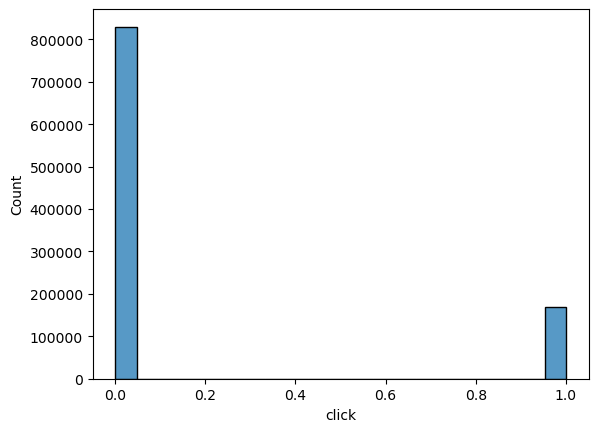

In [25]:
print(df["click"].value_counts())
sns.histplot(df, x="click")

We have a very unbalanced dataset. So, our first predictor will be a 0 - output model.

In [45]:
zero_predictor = np.zeros((df.shape[0], 2))
zero_predictor[:] = [1, 0]
print("Accuracy = ", accuracy_score(df['click'], zero_predictor[:, 1]))
print("Log loss = ", log_loss(df['click'], zero_predictor))

Accuracy =  0.830029
Log loss =  5.870590362619356


These are the initial values to beat. Through the notebook, we will of course rely more on the log loss. We will also use multiple types of encoding and want to have a feel whether we are doing something outlandish or not. So, we will use two models: logistic regression and xg boost, to have a feel on how well our data processing is doing.

In [183]:
def two_models(X_train, X_test, y_train, y_test, verbose=True, return_feats=False):
    #compute a simple logistic regression
    a = time.time()
    easy_lr = LogisticRegression(max_iter = 1000000)
    easy_lr.fit(X_train, y_train)
    b = time.time()
    
    #get metrics of the logistic regression
    time_lr = b - a
    lr_pred = easy_lr.predict(X_test)
    accuracy_lr = accuracy_score(y_test, lr_pred)
    lr_pred = easy_lr.predict_proba(X_test)
    log_loss_lr = log_loss(y_test, lr_pred)
    
    if verbose:
        print("\nLR Accuracy = ", accuracy_lr)
        print("LR Log loss = ", log_loss_lr)
        print("Execution   = ", time_lr, "secs")
    
    #compute a simple XGBoost
    a = time.time()
    easy_xg = XGBClassifier()
    easy_xg.fit(X_train, y_train)
    b = time.time()
    
    #get metrics of the XGBoost
    time_xg = b - a
    xg_pred = easy_xg.predict(X_test)
    accuracy_xg = accuracy_score(y_test, xg_pred)
    xg_pred = easy_xg.predict_proba(X_test)
    log_loss_xg = log_loss(y_test, xg_pred)
    
    if verbose:
        print("\nXGB Accuracy = ", accuracy_xg)
        print("XGB Log loss = ", log_loss_xg)
        print("Execution    = ", time_xg, "secs")

    #return metris if doing cross validation
    if return_feats:
        return np.array([accuracy_lr, log_loss_lr, time_lr, accuracy_xg, log_loss_xg, time_xg])
    #else return the models themselves
    else:
        return easy_lr, easy_xg

We will use a small sample of the data to perform the benchmarking with the two models. In future cells, we will perform 5 fold cross validation every time we test a new idea, with the function above.

We will use train_test_split because it allows us to stratify. As such:

`X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(df, df['click'], train_size = 0.8, stratify = df['click'])
X_train, X_test, y_train, y_test = train_test_split(X_test_big, y_test_big, train_size = 0.8, stratify = y_test_big)`

Another thing we will do to have an initial performance assesment is using the easiest columns and  one hot encoding the two object featues: `app_category` and `site_category`. We will not do anything with the numerical features (which are categorical in disguise). 

In [ ]:
easydf = df[easy_cols].copy()

In [58]:
dummy_site = pd.get_dummies(easydf['site_category'])
easydf[dummy_site.columns] = dummy_site
easydf.drop("site_category", inplace=True, axis = 1)
dummy_app = pd.get_dummies(easydf['app_category'])
easydf[dummy_app.columns] = dummy_app
easydf.drop("app_category", inplace=True, axis = 1)

In [59]:
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(easydf, df['click'], train_size = 0.8, stratify = df['click'])
X_train, X_test, y_train, y_test = train_test_split(X_test_big, y_test_big, train_size = 0.8, stratify = y_test_big)

In [71]:
lr, xgb = two_models(X_train, X_test, y_train, y_test)

LR Accuracy =  0.82905
LR Log loss =  0.4379220043890333
Execution   =  9.808510065078735 secs

XGB Accuracy =  0.830925
XGB Log loss =  0.4258507401965908
Execution    =  8.881041765213013 secs


These are the ACTUAL initial values to beat.

# Feature engineering and Exploration on easy columns

In [196]:
X = df[easy_cols].copy()
y = df['click'].copy()

In [192]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   banner_pos        1000000 non-null  int64 
 1   site_category     1000000 non-null  object
 2   app_category      1000000 non-null  object
 3   device_type       1000000 non-null  int64 
 4   device_conn_type  1000000 non-null  int64 
 5   C15               1000000 non-null  int64 
 6   C16               1000000 non-null  int64 
 7   C18               1000000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 61.0+ MB


In [84]:
one_hot_count = 0
for col in easy_cols:
    value_counts = X[col].value_counts()
    print(X[col].value_counts())
    one_hot_count += value_counts.index.shape[0]

1005    918606
1002     54907
1010     22409
1012      2854
1007       871
1001       222
1008       131
Name: C1, dtype: int64
0    719444
1    278805
7      1074
2       326
4       176
5       131
3        44
Name: banner_pos, dtype: int64
50e219e0    408921
f028772b    313339
28905ebd    182020
3e814130     75667
f66779e6      6365
75fa27f6      4007
335d28a8      3351
76b2941d      2573
c0dd3be3      1026
72722551       676
dedf689d       624
70fb0e29       608
0569f928       429
8fd0aea4       189
a818d37a        81
42a36e14        62
e787de0e        28
bcf865d9        16
5378d028        11
9ccfa2ea         5
da34532e         1
c706e647         1
Name: site_category, dtype: int64
07d7df22    647297
0f2161f8    236433
cef3e649     42612
8ded1f7a     36310
f95efa07     28298
d1327cf5      3106
09481d60      1403
dc97ec06      1358
75d80bbe      1003
fc6fa53d       597
4ce2e9fc       495
879c24eb       311
a3c42688       271
4681bb9d       159
0f9a328c       123
2281a340        69
a

nothing particularly remarkable for the value count. There are some categoires that only have one instance. We will (decided whether we) deal with that later.

In [86]:
print("Number of distinct categories = ", one_hot_count)

Number of distinct categories =  92


We can already observe from the easy columns that one hot encoding is not going to be a feasible solution. So we will have to come up with other ideas.

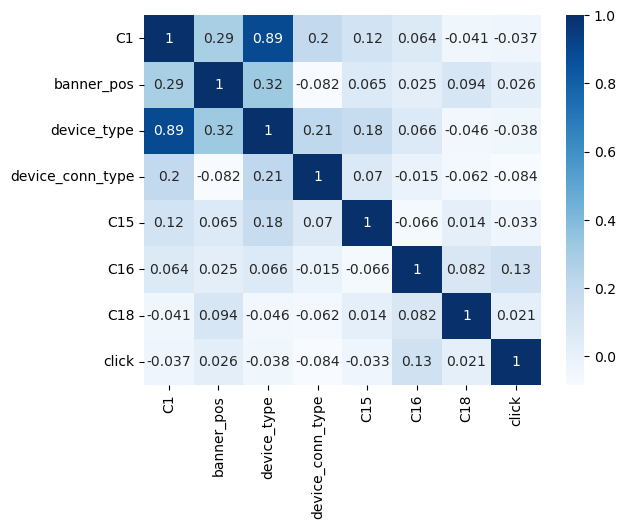

In [95]:
corr = (pd.concat([X, y], axis = 1)).corr()
plot = sns.heatmap(corr, cmap="Blues", annot=True)

From the correlation table above, we are particularly interested in the relationships between device_type, c1, and banner_pos.

In [110]:
X[['device_type', 'C1']].groupby('C1').value_counts().unstack()

device_type,0,1,2,4,5
C1,,,,,
1001,NaN,222.0,NaN,NaN,NaN
1002,54907.0,NaN,NaN,NaN,NaN
1005,NaN,918606.0,NaN,NaN,NaN
1007,NaN,871.0,NaN,NaN,NaN
1008,NaN,131.0,NaN,NaN,NaN
1010,NaN,NaN,NaN,19224.0,3185.0
1012,NaN,2853.0,1.0,NaN,NaN


We can check that `device_type` and `C1` are truly very similar. Every device value is almost one to one related to one C1 value. So, we will drop one of these two columns. We will preserve `device_type` because it has less categoires with small number of samples.

In [112]:
X[['device_type', 'banner_pos']].groupby('banner_pos').value_counts().unstack()

device_type,0,1,2,4,5
banner_pos,,,,,
0,54907.0,664526.0,1.0,2.0,8.0
1,NaN,257480.0,NaN,18350.0,2975.0
2,NaN,326.0,NaN,NaN,NaN
3,NaN,44.0,NaN,NaN,NaN
4,NaN,176.0,NaN,NaN,NaN
5,NaN,131.0,NaN,NaN,NaN
7,NaN,NaN,NaN,872.0,202.0


Although they look correlated (look at the 4 by 4 table of NaNs), we see the marix is still populated enough. No need to drop anything.

We will use three types of encoding (we will use one last type later).

correlation encoding = Correlation encoding is one way to encode a categorical feature with a high number K of distinct values, into a single integer that goes from 0 to K-1. We calculate the correlation coefficient with some target column (clicks) and arrenge these correlations in ascending order. The value of the new feature will be equal to the index of the corresponding correlation. In this way, solvers like logistic regression will have an easier time assigning big values to features that we know from training are positively correlated with the target column (click), or small values if they are very negatively correlated. And, by making these values integers, the tree-based solvers such as xgboost and random forest wont have trouble separating them.

one hot encoding = Creates binary columns for each unique category and assigns a 1 to the corresponding column for each row. Generates a huge number of column features in a sparse format.


Target encoding = Features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.


In [12]:
def correlation_encode(init_df, init_col, target_col):
    # create our new feature
    new_col = 'encoded_' + init_col
    init_df[new_col] = 0
    
    # get the correlations and sort them
    correlations = pd.get_dummies(init_df[init_col]).corrwith(target_col).sort_values(ascending=True)

    # assign the index of the sorted correlation list
    for i, j in enumerate(correlations.index.tolist()):
        init_df.loc[init_df[init_col] == j, new_col] = i
    
    # drop the previous column
    init_df.drop(init_col, inplace= True, axis = 1)
    
    # we will return the correlation index to encode the test data. Observe
    # that we are not contaminating the dataset because the order of the correlation list
    # is only calculatied on training
    return correlations.index.tolist()

def one_hot_encode(init_df, init_col):
    # pandas one hot encoding
    dummy_cols = pd.get_dummies(init_df[init_col])
    init_df[dummy_cols.columns] = dummy_cols
    # drop the old column
    init_df.drop(init_col, inplace= True, axis = 1)

def target_encode(init_df, init_col, target_col):
    # we use categorical_encoder implementation
    encoder = ce.TargetEncoder()
    # new columns
    new_col = 'encoded_' + init_col
    # we cast as type object because leaving the feature as integers will output the same integer value
    init_df[new_col] = encoder.fit_transform(init_df[init_col].astype('object'), target_col)
    # drop the column
    init_df.drop(init_col, inplace= True, axis = 1)
    # return the encoder for test data encoding
    return encoder    

In [13]:
def correlation_encode_transform(init_df, init_col, correlations):
    new_col = 'encoded_' + init_col
    init_df[new_col] = 0

    middle_bin = len(correlations)/2
    for i, j in enumerate(correlations):
        # if we are encoding a value not seen in training, place it in the middle
        # of the correlation list. 
        if ((init_df[init_col] == j).sum() == 0):
            init_df.loc[init_df[init_col] == j, new_col] = middle_bin
        else:
            init_df.loc[init_df[init_col] == j, new_col] = i
    
    init_df.drop(init_col, inplace= True, axis = 1)

def target_encode_transform(init_df, init_col, encoder):
    new_col = 'encoded_' + init_col
    init_df[new_col] = encoder.transform(init_df[init_col])
    init_df.drop(init_col, inplace= True, axis = 1)
    return encoder

Now, we will evaluate through cross validation how well each of these encodings perform on the dataset. We are interested in K-folding because the improvements of our metrics, namely log loss and accuracy, are being compared from 2 to 5 decimal places of accuracy. We do not want a lucky training phase to misinform our decisions (which vairables to merge, which to encode, etc).

In [226]:
to_encode = ["banner_pos", "site_category", "app_category", "device_type", "device_conn_type", "C15", "C16", "C18"]

#by calling the columns = to_encode, we are dropping c1
# We want to train on a small sample of data to make the training time shorter.
X_, _, y_, _ = train_test_split(X[to_encode], y, stratify=y, train_size = 0.4)

#this object will allows to perform a 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [221]:
values = np.zeros(6)

for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index].copy(), X_.iloc[test_index].copy()
    y_train, y_test = y_.iloc[train_index].copy(), y_.iloc[test_index].copy()
    
    for col in to_encode:
        one_hot_encode(X_train, col)
        one_hot_encode(X_test, col)
        
    #we allign in the case of unseen values during the one hot encoding of the test data
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)
        
    values = values + two_models(X_train.values, X_test.values, y_train, y_test, verbose=False, return_feats=True)
    
values = values / 5
print("One hot encoding stats: ")
print("\nAvg LR Accuracy = ", values[0])
print("Avg LR Log loss = ", values[1])
print("Avg Execution   = ", values[2], "secs")
print("\nAvg XGB Accuracy = ", values[3])
print("Avg XGB Log loss = ", values[4])
print("Avg Execution    = ", values[5], "secs")

One hot encoding stats: 

Avg LR Accuracy =  0.8305875
Avg LR Log loss =  0.4312086909642051
Avg Execution   =  6.95037579536438 secs

Avg XGB Accuracy =  0.8311
Avg XGB Log loss =  0.4273378388122868
Avg Execution    =  19.895331287384032 secs


In [218]:
values = np.zeros(6)
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index].copy(), X_.iloc[test_index].copy()
    y_train, y_test = y_.iloc[train_index].copy(), y_.iloc[test_index].copy()
    
    for col in to_encode:
        corr_encoder = correlation_encode(X_train, col, y_train)
        correlation_encode_transform(X_test, col, corr_encoder)
        
    values = values + two_models(X_train, X_test, y_train, y_test, verbose=False, return_feats=True)
    
values = values / 5

print("Correlation encoding stats: ")
print("\nAvg LR Accuracy = ", values[0])
print("Avg LR Log loss = ", values[1])
print("Avg Execution   = ", values[2], "secs")
print("\nAvg XGB Accuracy = ", values[3])
print("Avg XGB Log loss = ", values[4])
print("Avg Execution    = ", values[5], "secs") 

Correlation encoding stats: 

Avg LR Accuracy =  0.83003
Avg LR Log loss =  0.4357549696742371
Avg Execution   =  0.9008316040039063 secs

Avg XGB Accuracy =  0.831285
Avg XGB Log loss =  0.42451968592172573
Avg Execution    =  5.581271696090698 secs


In [219]:
values = np.zeros(6)

for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index].copy(), X_.iloc[test_index].copy()
    y_train, y_test = y_.iloc[train_index].copy(), y_.iloc[test_index].copy()

    for col in to_encode:
        target_encoder = target_encode(X_train, col, y_train)
        target_encode_transform(X_test, col, target_encoder)
        
    values = values + two_models(X_train.values, X_test.values, y_train, y_test, verbose=False, return_feats=True)

values = values / 5
print("Target encoding stats: ")
print("\nAvg LR Accuracy = ", values[0])
print("Avg LR Log loss = ", values[1])
print("Avg Execution   = ", values[2], "secs")
print("\nAvg XGB Accuracy = ", values[3])
print("Avg XGB Log loss = ", values[4])
print("Avg Execution    = ", values[5], "secs")

Target hot encoding stats: 

Avg LR Accuracy =  0.830035
Avg LR Log loss =  0.43334350759523954
Avg Execution   =  0.8533361434936524 secs

Avg XGB Accuracy =  0.8313174999999999
Avg XGB Log loss =  0.42448847704480885
Avg Execution    =  5.198725986480713 secs


We have a few interesting reads from these values. First of all, we confirm that one hot encoding takes between 4 and 20 times more for a model to train, while not improving the model in any of our metric by a significant amount. So, we will stop considering this option.

It seems that our correlation encoding and target encoding work very similarly in terms of execution speed, accruacy, and log loss (marginal improvements through target encoding). 

Rerunning the cells above without dropping C1 show: the log loss for our target-encoded logistic-regression increases to 0.45; and the accuracy for the correlated-encoded XGBoost increases to 0.8315. Other than that, there are no major changes, so we choose not to show this work.

In [574]:
#to avoid future repetion of the cells above, we create the following function

def two_models_CV(X_, y_, to_encode, encoding, transform_encoding, message=None, is_encoding=True):
    values = np.zeros(6)

    for train_index, test_index in kf.split(X_):
        X_train, X_test = X_.iloc[train_index].copy(), X_.iloc[test_index].copy()
        y_train, y_test = y_.iloc[train_index].copy(), y_.iloc[test_index].copy()

        for col in to_encode:
            target_encoder = encoding(X_train, col, y_train)
            transform_encoding(X_test, col, target_encoder)

        values = values + two_models(X_train.values, X_test.values, y_train, y_test, verbose=False, return_feats=True)

    values = values / 5
    print(f"{message + ' '} Stats: ")
    print("\nAvg LR Accuracy = ", values[0])
    print("Avg LR Log loss = ", values[1])
    print("Avg Execution   = ", values[2], "secs")
    print("\nAvg XGB Accuracy = ", values[3])
    print("Avg XGB Log loss = ", values[4])
    print("Avg Execution    = ", values[5], "secs")

# Feature engineering and Exploration on medium Columns

In [293]:
#easy_cols.remove('C1')

In [344]:
X = df[easy_cols + medium_cols + ['hour']].copy()
y = df['click'].copy()

In [345]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   banner_pos        1000000 non-null  int64 
 1   site_category     1000000 non-null  object
 2   app_category      1000000 non-null  object
 3   device_type       1000000 non-null  int64 
 4   device_conn_type  1000000 non-null  int64 
 5   C15               1000000 non-null  int64 
 6   C16               1000000 non-null  int64 
 7   C18               1000000 non-null  int64 
 8   app_domain        1000000 non-null  object
 9   C20               1000000 non-null  int64 
 10  C17               1000000 non-null  int64 
 11  hour              1000000 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 91.6+ MB


In [346]:
for col in medium_cols:
    value_counts = X[col].value_counts()
    print(X[col].value_counts())

7801e8d9    673864
2347f47a    129388
ae637522     46638
5c5a694b     28019
82e27996     18727
             ...  
26894d3c         1
bb27eb10         1
6f406d5b         1
1d1d4953         1
a5ab1a9f         1
Name: app_domain, Length: 198, dtype: int64
-1         468959
 100084     60183
 100148     44519
 100111     41902
 100077     39088
            ...  
 100157         2
 100098         2
 100100         1
 100246         1
 100078         1
Name: C20, Length: 163, dtype: int64
1722    111327
2424     37931
2227     36296
1800     29272
423      23520
         ...  
2448         1
2465         1
2568         1
2084         1
2585         1
Name: C17, Length: 420, dtype: int64


We observe that many categories have counts of 1. Because our correlation encoding relies on the **ordering** of correlations, one problem would come from having too many categoires with just a few values. These would result in correlations of 1 or -1, which would populate the head and tail of the correlations list. Then, the feature's variance would be too high.

Similar things would happen to our target encoding, where we assign 1 (the highest value) to a category that only has one positve sample, or 0 otherwise. 

We will now experiment with the idea of binning data with too little samples into a single category.

One nice outcome of our two encodings is that we are now "immune" to datapoints with no information. Observe, for example, C20, which has 46000 samples with a -1 value. If we considered C20 a numerical feature, our solver would need to deal with the huge gaps between -1 (no data) and 100084 (actual data). However, correlation and target encoding deal with this.

In [347]:
def binning(X, col, threshold):
    counts = X[col].value_counts()
    few_samples_categories = counts[counts < threshold].index
    X.loc[X[col].isin(few_samples_categories), col] = -1


We work the time column.

In [348]:
X['weekday'] = X['hour'].apply(lambda x:datesplit(x).weekday())
X['clock'] = X['hour'].apply(lambda x:datesplit(x).hour)

In [299]:
months = X['hour'].apply(lambda x:datesplit(x).month)
months.nunique()

1

We see that month is only 1, so this feature would not contribute anything. Of course, neither will the year. Since `weekday` and `time` follow a natural numerical progression, we will not encode this data.

In [ ]:
X.drop('hour', axis = 1, inplace = True)
medium_cols.remove('hour')

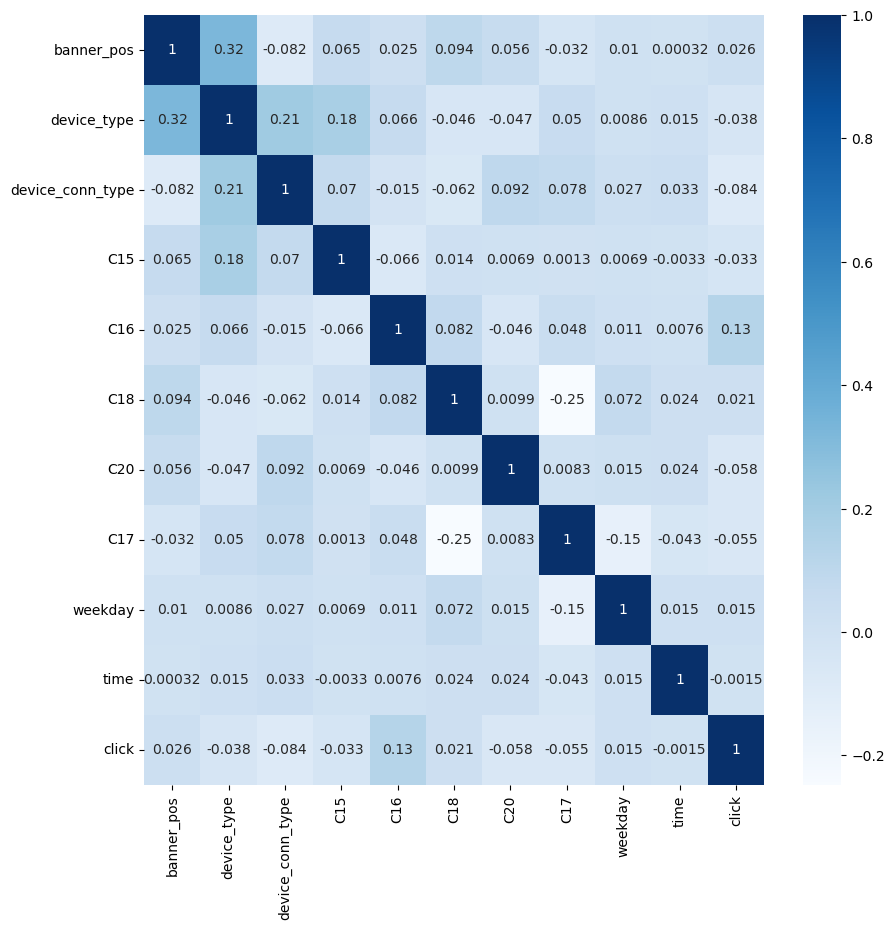

In [314]:
fig, ax = plt.subplots(figsize=(10, 10))

corr = (pd.concat((X, y), axis = 1)).corr()
hm = sns.heatmap(corr, cmap="Blues", annot=True)
ticks = np.arange(corr.shape[0]) + 0.5


No feature relationship looks partircularly interesting besides C17 and C18. We might go back to this later

In [302]:
to_encode = easy_cols + medium_cols

# We want to train on a small sample of data to make the training time shorter.
X_, _, y_, _ = train_test_split(X, y, stratify=y, train_size = 0.4)

#this object will allows to perform a 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [308]:
two_models_CV(X_ , y_, to_encode, correlation_encode, correlation_encode_transform, message="Correlate encode")

Correlate encode  Stats: 

Avg LR Accuracy =  0.83003
Avg LR Log loss =  0.4256068509854683
Avg Execution   =  10.35270881652832 secs

Avg XGB Accuracy =  0.8333775000000001
Avg XGB Log loss =  0.41039585488775343
Avg Execution    =  8.758821630477906 secs


In [309]:
two_models_CV(X_ , y_, to_encode, target_encode, target_encode_transform, message="Target encode")

Target encode  Stats: 

Avg LR Accuracy =  0.831795
Avg LR Log loss =  0.4221183486287652
Avg Execution   =  4.464787006378174 secs

Avg XGB Accuracy =  0.8333725000000001
Avg XGB Log loss =  0.41069287791052
Avg Execution    =  8.444140672683716 secs


We are interested in whether the encodings reveal to us some new information about the dataset. For that, we look again at the correlations.

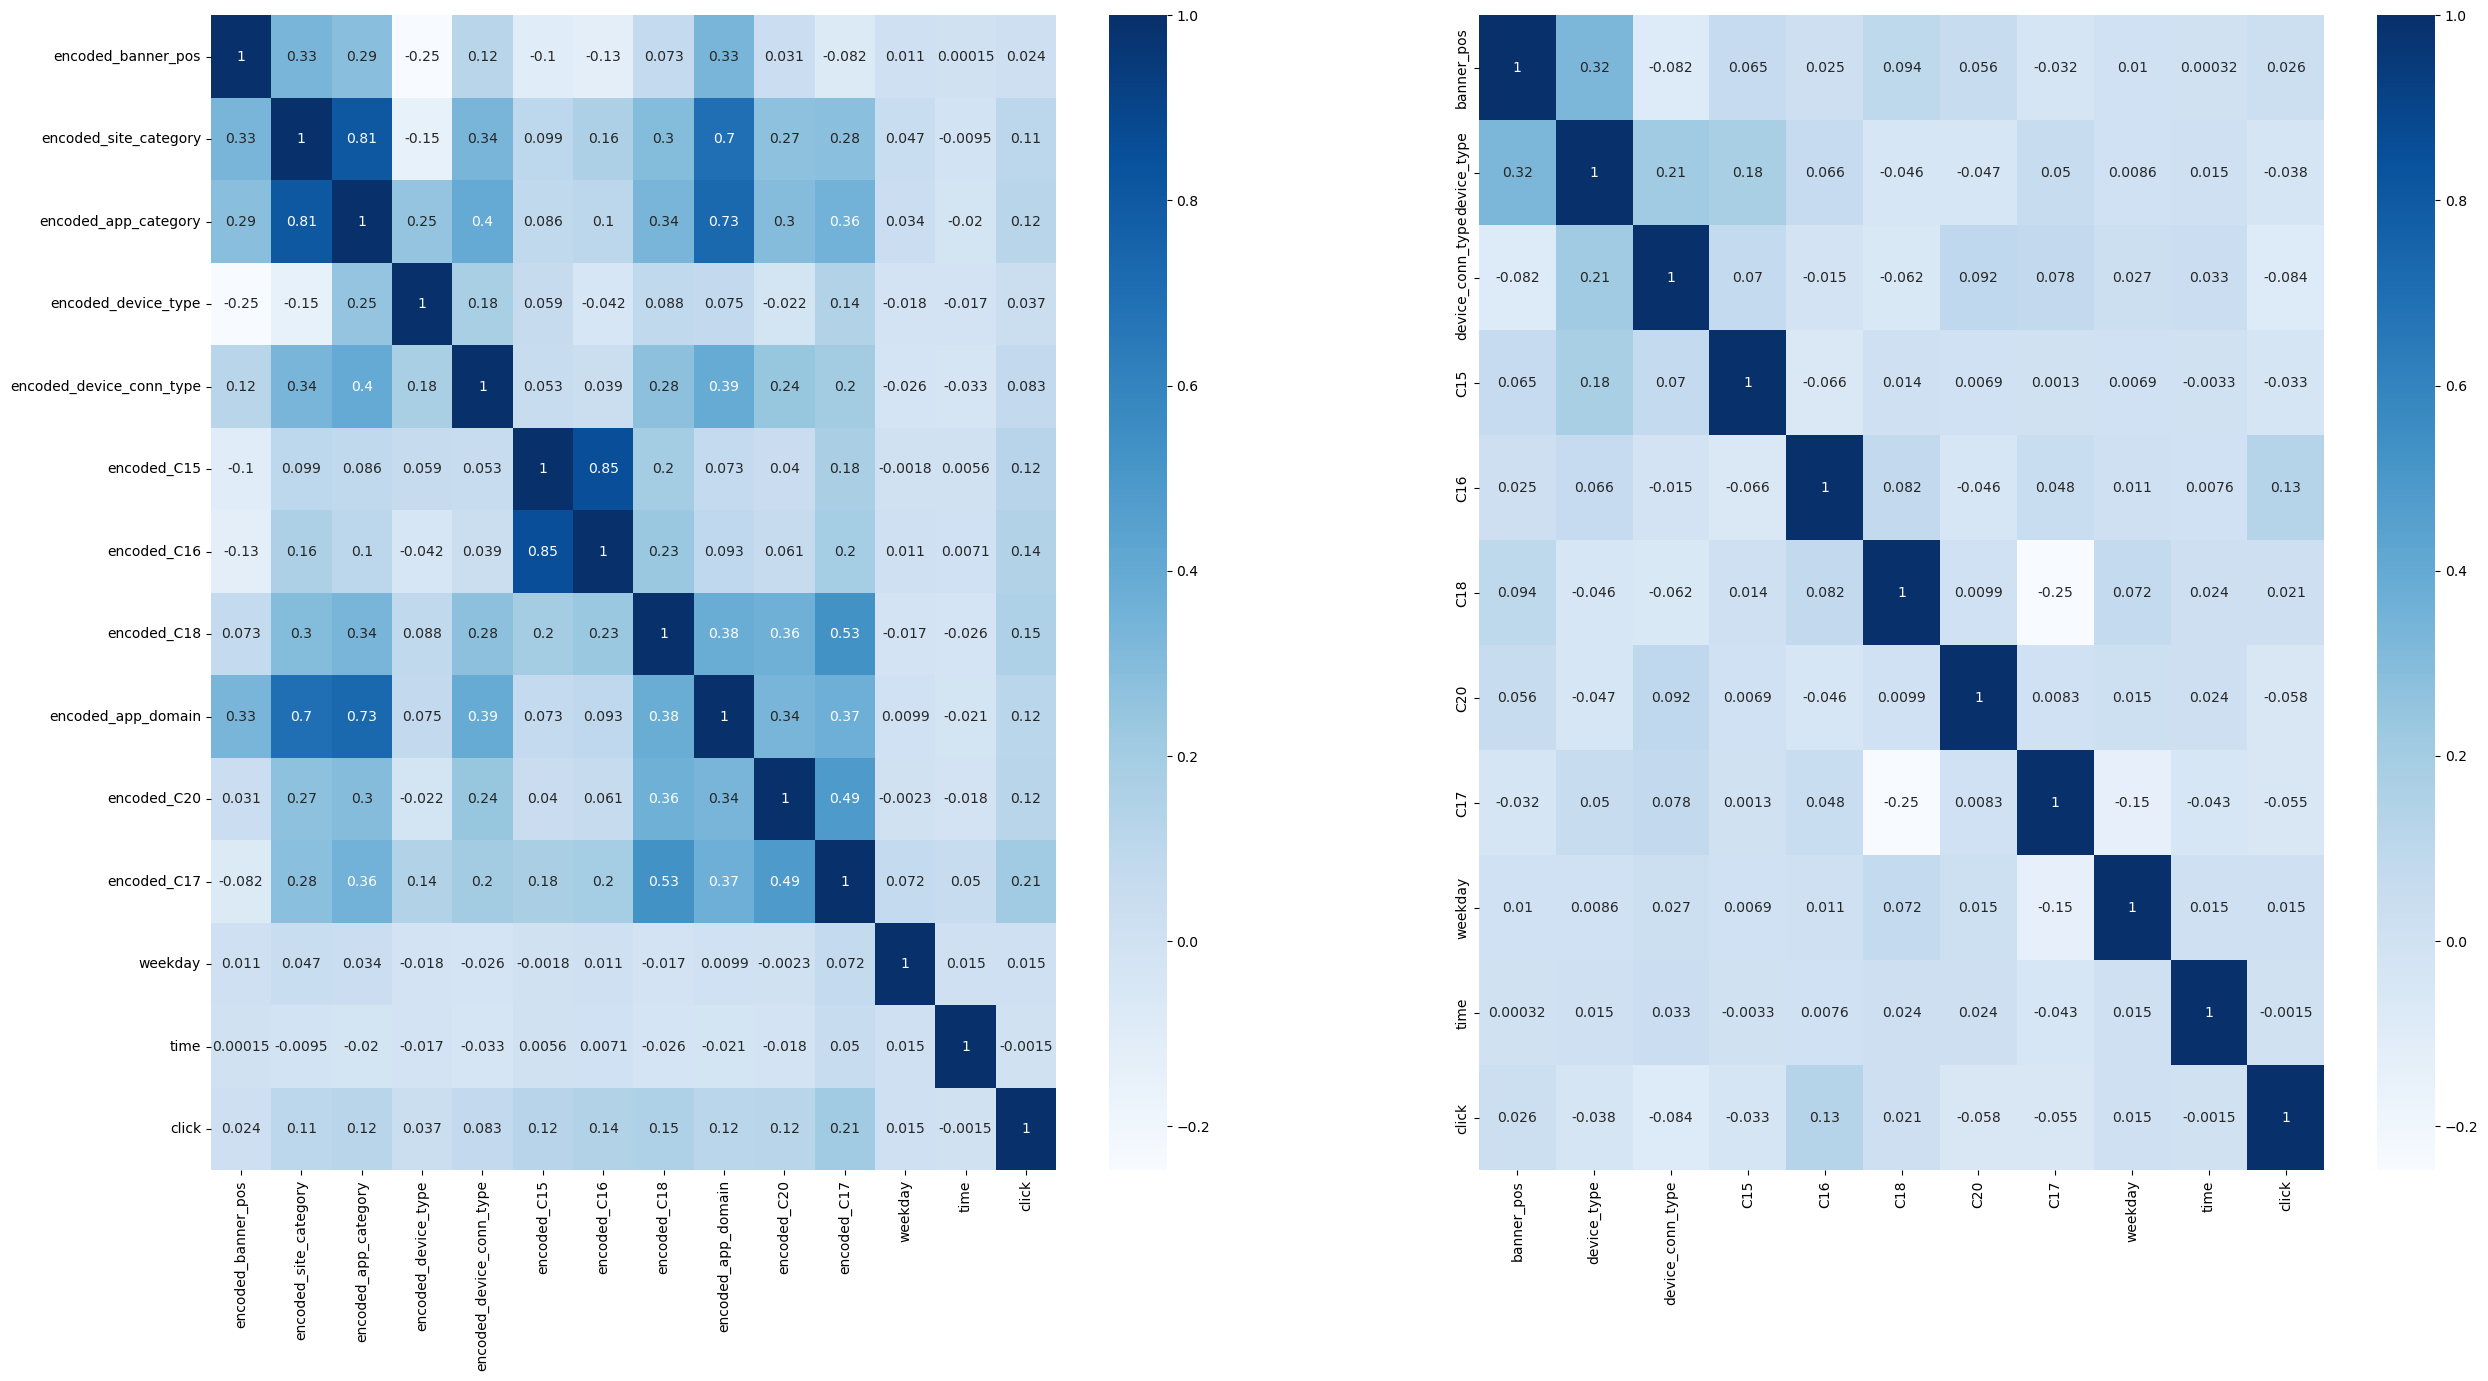

In [352]:
X_correlation = X.copy()

for col in to_encode:
    corr_encoder = correlation_encode(X_correlation, col, y)

col = X_correlation.pop('weekday')
X_correlation = pd.concat((X_correlation, col), axis=1)
col = X_correlation.pop('clock')
X_correlation = pd.concat((X_correlation, col), axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))

corr = (pd.concat((X_correlation, y), axis = 1)).corr()
hm = sns.heatmap(corr, cmap="Blues", annot=True, ax=axes[0])
ticks = np.arange(corr.shape[0]) + 0.5

corr = (pd.concat((X, y), axis = 1)).corr()
hm = sns.heatmap(corr, cmap="Blues", annot=True, ax=axes[1])
ticks = np.arange(corr.shape[0]) + 0.5

Based on the correlation table to the left, which is the correlation table after correlation encoding, we are interested in the following relationships:  `C15` and `C16`; `app_domain` and `app_category`; `app_category` and `site_category`.

In [355]:
X_correlation[['encoded_C15', 'encoded_C16']].groupby('encoded_C16').value_counts().unstack()

encoded_C15,0,1,2,3,4,5,6,7
encoded_C16,,,,,,,,
0,930613.0,NaN,NaN,NaN,NaN,NaN,NaN,13061.0
1,NaN,1810.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,7345.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,89.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,56.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN
7,2475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44431.0


In [356]:
X[['C15', 'C16']].groupby('C16').value_counts().unstack()

C15,120,216,300,320,480,728,768,1024
C16,,,,,,,,
20,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,7345.0,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,13061.0,930613.0,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN,1810.0,NaN,NaN
250,NaN,NaN,44431.0,NaN,NaN,NaN,NaN,NaN
320,NaN,NaN,NaN,NaN,56.0,NaN,NaN,NaN
480,NaN,NaN,NaN,2475.0,NaN,NaN,NaN,NaN
768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0
1024,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN


Indeed we can observe that `C15` and `C16` are highly correlated. The features are almost one to one. This discovery makes me very happy because I spent hours coding the correlation encode and it finally revealed to us some useful information. In order not to lose any information, we will create a new column `C40` that simply multiplies both values. Then we will encode it.

In [366]:
X['C40'] = X['C15'] * X['C16']
easy_cols = easy_cols + ['C40']

In [373]:
print("Number of non-nan columns (app_category) for every row (app_domain) in the count matrix")
print(X_correlation[['encoded_app_domain', 'encoded_app_category']].groupby('encoded_app_domain').value_counts().unstack().count())

Number of non-nan columns (app_category) for every row (app_domain) in the count matrix
encoded_app_category
0     87
1     19
2     25
3      8
4     15
5     15
6     42
7      1
8      7
9     11
10     6
11     9
12     1
13     8
14     2
15     1
16     4
17     1
18     1
19     1
20     1
21     8
22     3
23     2
24    16
25     2
dtype: int64


There are still some distict values, so we will not merge these categories.

In [376]:
print("Number of non-nan columns (app_category) for every row (site_category) in the count matrix")
print(X[['site_category', 'app_category']].groupby('site_category').value_counts().unstack().count())

Number of non-nan columns (app_category) for every row (site_category) in the count matrix
app_category
07d7df22    22
09481d60     1
0bfbc358     1
0f2161f8     1
0f9a328c     1
18b1e0be     1
2281a340     1
2fc4f2aa     1
4681bb9d     1
4ce2e9fc     1
5326cf99     1
7113d72a     1
75d80bbe     1
79f0b860     1
86c1a5a3     1
879c24eb     1
8ded1f7a     1
8df2e842     1
a3c42688     1
a7fd01ec     1
a86a3e89     1
cef3e649     1
d1327cf5     1
dc97ec06     1
f95efa07     1
fc6fa53d     1
dtype: int64


Indeed, the relationship is almost one to one. We will merge these into a new feature called `category`

In [ ]:
X['category'] = X['app_category'] + X['site_category']

In [385]:
X.drop(columns = ['app_category', 'site_category', 'C15', 'C16'], inplace = True, axis = 1)

In [484]:
easy_cols_2 = ['banner_pos','category','device_type','device_conn_type','C18','C40']

In [522]:
medium_cols_2 = ['app_domain', 'C20', 'C17']
hour = ['weekday', 'clock']

In [394]:
to_encode = easy_cols_2 + medium_cols_2
# We want to train on a small sample of data to make the training time shorter.
X_, _, y_, _ = train_test_split(X, y, stratify=y, train_size = 0.4)

#this object will allows to perform a 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

two_models_CV(X_ , y_, to_encode, correlation_encode, correlation_encode_transform, message="Correlate encode")
two_models_CV(X_ , y_, to_encode, target_encode, target_encode_transform, message="Target encode")

Correlate encode  Stats: 

Avg LR Accuracy =  0.83003
Avg LR Log loss =  0.42588197626499447
Avg Execution   =  6.617514801025391 secs

Avg XGB Accuracy =  0.83291
Avg XGB Log loss =  0.41111794763486537
Avg Execution    =  8.208365345001221 secs
Target encode  Stats: 

Avg LR Accuracy =  0.8313325
Avg LR Log loss =  0.4222511069094839
Avg Execution   =  3.393069267272949 secs

Avg XGB Accuracy =  0.8329725
Avg XGB Log loss =  0.4114299896559056
Avg Execution    =  7.965106582641601 secs


Our metrics do not improve (in fact, they get a bit worse). However, our model trains faster. We will see what to do with this later.

The final thing to do is bining. We do this for both the newly added features.

In [398]:
#binning with a threshold of 30
X_30 = X_.copy()

for col in easy_cols + medium_cols:
    binning(X_30, col , 30)

two_models_CV(X_30 , y_, to_encode, correlation_encode, correlation_encode_transform, message="Correlate encode")
two_models_CV(X_30 , y_, to_encode, target_encode, target_encode_transform, message="Target encode")

Correlate encode  Stats: 

Avg LR Accuracy =  0.83003
Avg LR Log loss =  0.4258598904411861
Avg Execution   =  6.495601177215576 secs

Avg XGB Accuracy =  0.8327674999999999
Avg XGB Log loss =  0.41114290521246044
Avg Execution    =  8.363866806030273 secs
Target encode  Stats: 

Avg LR Accuracy =  0.8314050000000002
Avg LR Log loss =  0.42232497217980425
Avg Execution   =  3.9829763412475585 secs

Avg XGB Accuracy =  0.8328949999999999
Avg XGB Log loss =  0.41144015232049486
Avg Execution    =  8.781234836578369 secs


In [399]:
#binning with a threshold of 200
X_200 = X_.copy()

for col in easy_cols + medium_cols:
    binning(X_200, col , 200)

two_models_CV(X_200 , y_, to_encode, correlation_encode, correlation_encode_transform, message="Correlate encode")
two_models_CV(X_200 , y_, to_encode, target_encode, target_encode_transform, message="Target encode")

Correlate encode  Stats: 

Avg LR Accuracy =  0.83003
Avg LR Log loss =  0.42643939543047277
Avg Execution   =  4.065802526473999 secs

Avg XGB Accuracy =  0.8328225
Avg XGB Log loss =  0.41132667856404764
Avg Execution    =  8.53501000404358 secs
Target encode  Stats: 

Avg LR Accuracy =  0.8313175000000002
Avg LR Log loss =  0.4232232491433588
Avg Execution   =  3.8526028633117675 secs

Avg XGB Accuracy =  0.8329375000000001
Avg XGB Log loss =  0.4114325977384706
Avg Execution    =  8.131659603118896 secs


Nothing particularly remarkable. Since they do not provide much difference, we will not do it anymore.

# Feature engineering and Exploration on hard Columns

In [528]:
X = df[easy_cols + medium_cols + hard_cols].copy()
y = df['click'].copy()

In [529]:
X[hard_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   device_id     1000000 non-null  object
 1   device_ip     1000000 non-null  object
 2   device_model  1000000 non-null  object
 3   app_id        1000000 non-null  object
 4   site_domain   1000000 non-null  object
 5   site_id       1000000 non-null  object
 6   C14           1000000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 53.4+ MB


In [538]:
X[hard_cols].nunique()

device_id       150501
device_ip       555248
device_model      5168
app_id            3157
site_domain       2871
site_id           2651
C14               2243
dtype: int64

It is not unreasonable to believe that device_id and device_ip are correlated to each other. We will test how much by creating a new feature called device

In [448]:
X['device'] = X['device_id'] + X['device_ip']
X[['device_id', 'device_ip', 'device']].nunique()

device_id    150501
device_ip    555248
device       609105
dtype: int64

In [449]:
609105 /(555248 * 150501)

7.288963509545467e-06

Out of the possible 150501 * 555248 = 83565379248 possible `device_id`, `device_ip` combinations, we only see 609105 (less than 0.0008% of the total combinations). So the date is indeed highly dependant (surprise! ... not really). We might miss the two degrees of freedom so we will not combine them into a single category.  

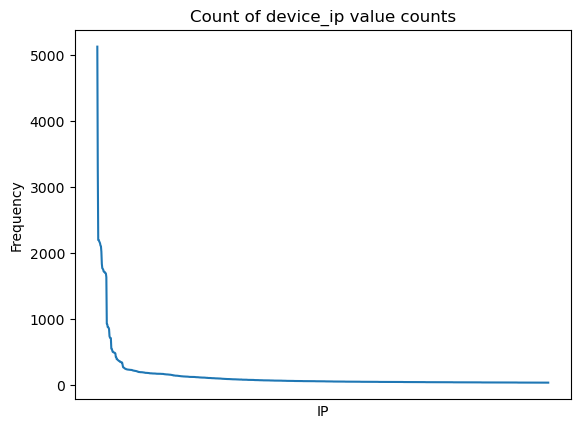

In [478]:
ip_counts = X['device_ip'].value_counts() 
plt.plot(ip_counts[:1000])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.xlabel('IP')
plt.ylabel('Frequency')

plt.title('Count of device_ip value counts')
plt.show()

In [451]:
for col in hard_cols:
    value_counts = X[col].value_counts()
    print(X[col].value_counts())

a99f214a    824918
0f7c61dc       512
c357dbff       481
936e92fb       366
afeffc18       242
             ...  
98fcb9ef         1
ceb4ddfc         1
0eabc47f         1
4c6417bb         1
aab31253         1
Name: device_id, Length: 150501, dtype: int64
6b9769f2    5130
431b3174    3291
2f323f36    2197
930ec31d    2196
285aa37d    2181
            ... 
9a34079d       1
d78c2be9       1
68b28485       1
ea9c002b       1
3ca7f719       1
Name: device_ip, Length: 555248, dtype: int64
8a4875bd    60790
1f0bc64f    35103
d787e91b    34780
76dc4769    18663
be6db1d7    18357
            ...  
0bbd5ecd        1
4b0d3c7e        1
52b9ae0f        1
e207ef57        1
78cd4bd4        1
Name: device_model, Length: 5168, dtype: int64
ecad2386    639089
92f5800b     38643
e2fcccd2     28008
9c13b419     18820
febd1138     18726
             ...  
2c3336ca         1
ee3d199e         1
276d6d97         1
b8171d73         1
1017e2d5         1
Name: app_id, Length: 3157, dtype: int64
c4e18dd6    37415

Here we will face again the problem of having categories with too little samples. To combat this we will use one last type of encoding: count encoding. This encoding simply assigns as the new feature value, the count of the original feature. In this way, all the datapoints which categories had the same count, will end up in the same new category. Therefore, all the categories with a single sample end up in the same bin (the bin = 1). This is exactly what we wnat.

Despite providing this useful binning, we might still end up with an informationless feature. To provide more meaning to it, we will target encode it.

For the hard columns, we will not be able to take advantage of correlation encoding because this technique relies on first getting the dummy variables for each category. After that, we perform the correlation with the target columns. Since every feature column has over 1000 different values, the computational expense is prohibitive. 

In [14]:
def count_encode(init_df, init_col, target_col):
    # define the encoder
    count_encoder = ce.CountEncoder()
    
    # we cast the column as type object.  If we leave it as int, 
    # the encoder will not perform any action.
    
    init_df[init_col] = count_encoder.fit_transform(X[init_col].astype('object'))
    
    # now we target encode the newly generated feature
    target_encoder = target_encode(init_df, init_col, target_col)
    
    # we return the count and target encoder so that we encode test data without 
    # cross contaminaiton
    return (count_encoder, target_encoder)
 
def count_encode_transform(init_df, init_col, encoders):
    count_encoder, target_encoder = encoders
    #we encode count encode data
    init_df[init_col] = count_encoder.transform(init_df[init_col].astype('object'))
    #then target encode
    target_encode_transform(init_df, init_col, target_encoder)
    return count_encoder, target_encoder


In [480]:
hard_cols = ["device_id", "device_ip", "device_model", "app_id", "site_domain", "site_id", "C14"]
hard_cols_2 = ["device_model", "app_id", "site_domain", "site_id", "C14"]

In [472]:
X_, _, y_, _ = train_test_split(X, y, stratify=y, train_size = 0.4)

#this object will allows to perform a 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
to_encode = easy_cols + medium_cols + hard_cols

two_models_CV(X_ , y_, to_encode, count_encode, count_encode_transform, message="Count encode")
two_models_CV(X_ , y_, to_encode, target_encode, target_encode_transform, message="Target encode")

Count encode  Stats: 

Avg LR Accuracy =  0.8337749999999999
Avg LR Log loss =  0.40754671879429516
Avg Execution   =  2.6406223297119142 secs

Avg XGB Accuracy =  0.8346375
Avg XGB Log loss =  0.40091246859050056
Avg Execution    =  10.999122190475465 secs
Target encode  Stats: 

Avg LR Accuracy =  0.8061625000000001
Avg LR Log loss =  0.564135359168344
Avg Execution   =  2.041073799133301 secs

Avg XGB Accuracy =  0.8153775
Avg XGB Log loss =  0.6582366144894087
Avg Execution    =  12.789619255065919 secs


We observe that our count encoding does improve the results of the algorithm. However, we note how poorly the purely-target-encoded dataset performed (we probably overfitted with the meaningless 1s and 0s of the categories with one sample)  

In [531]:
X['weekday'] = X['hour'].apply(lambda x:datesplit(x).weekday())
X['clock'] = X['hour'].apply(lambda x:datesplit(x).hour)
X.drop(['hour'], axis= 1, inplace = True)

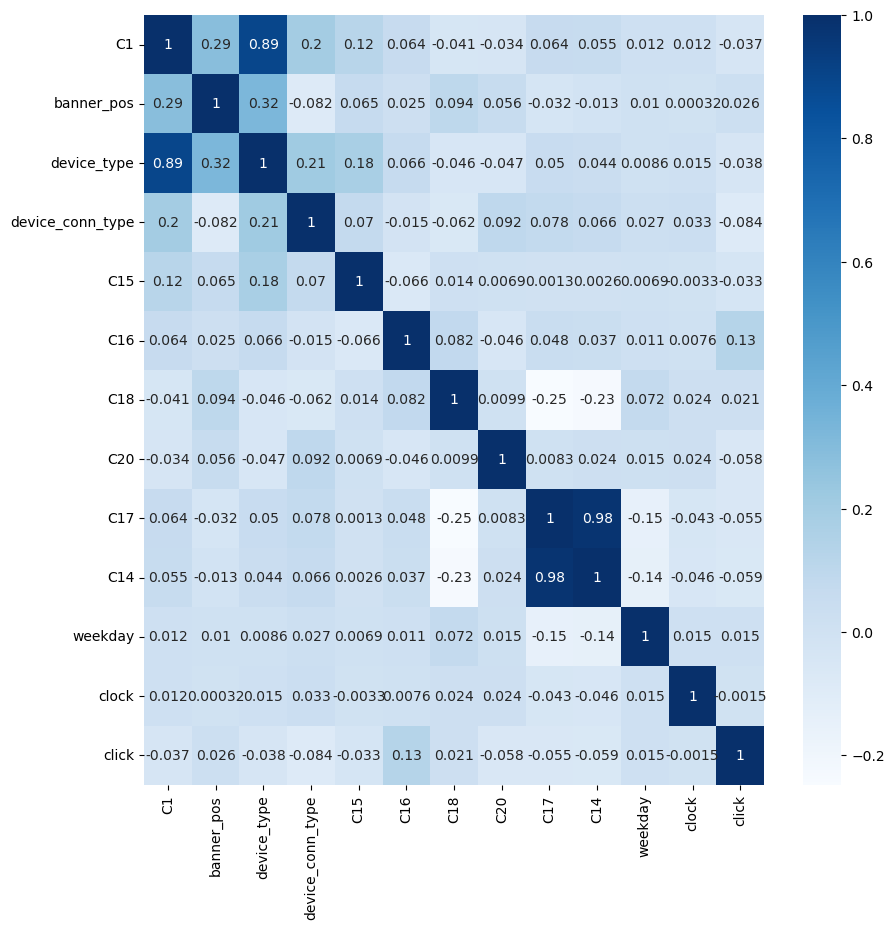

In [532]:
fig, ax = plt.subplots(figsize=(10, 10))

corr = (pd.concat((X, y), axis = 1)).corr()
hm = sns.heatmap(corr, cmap="Blues", annot=True)
ticks = np.arange(corr.shape[0]) + 0.5

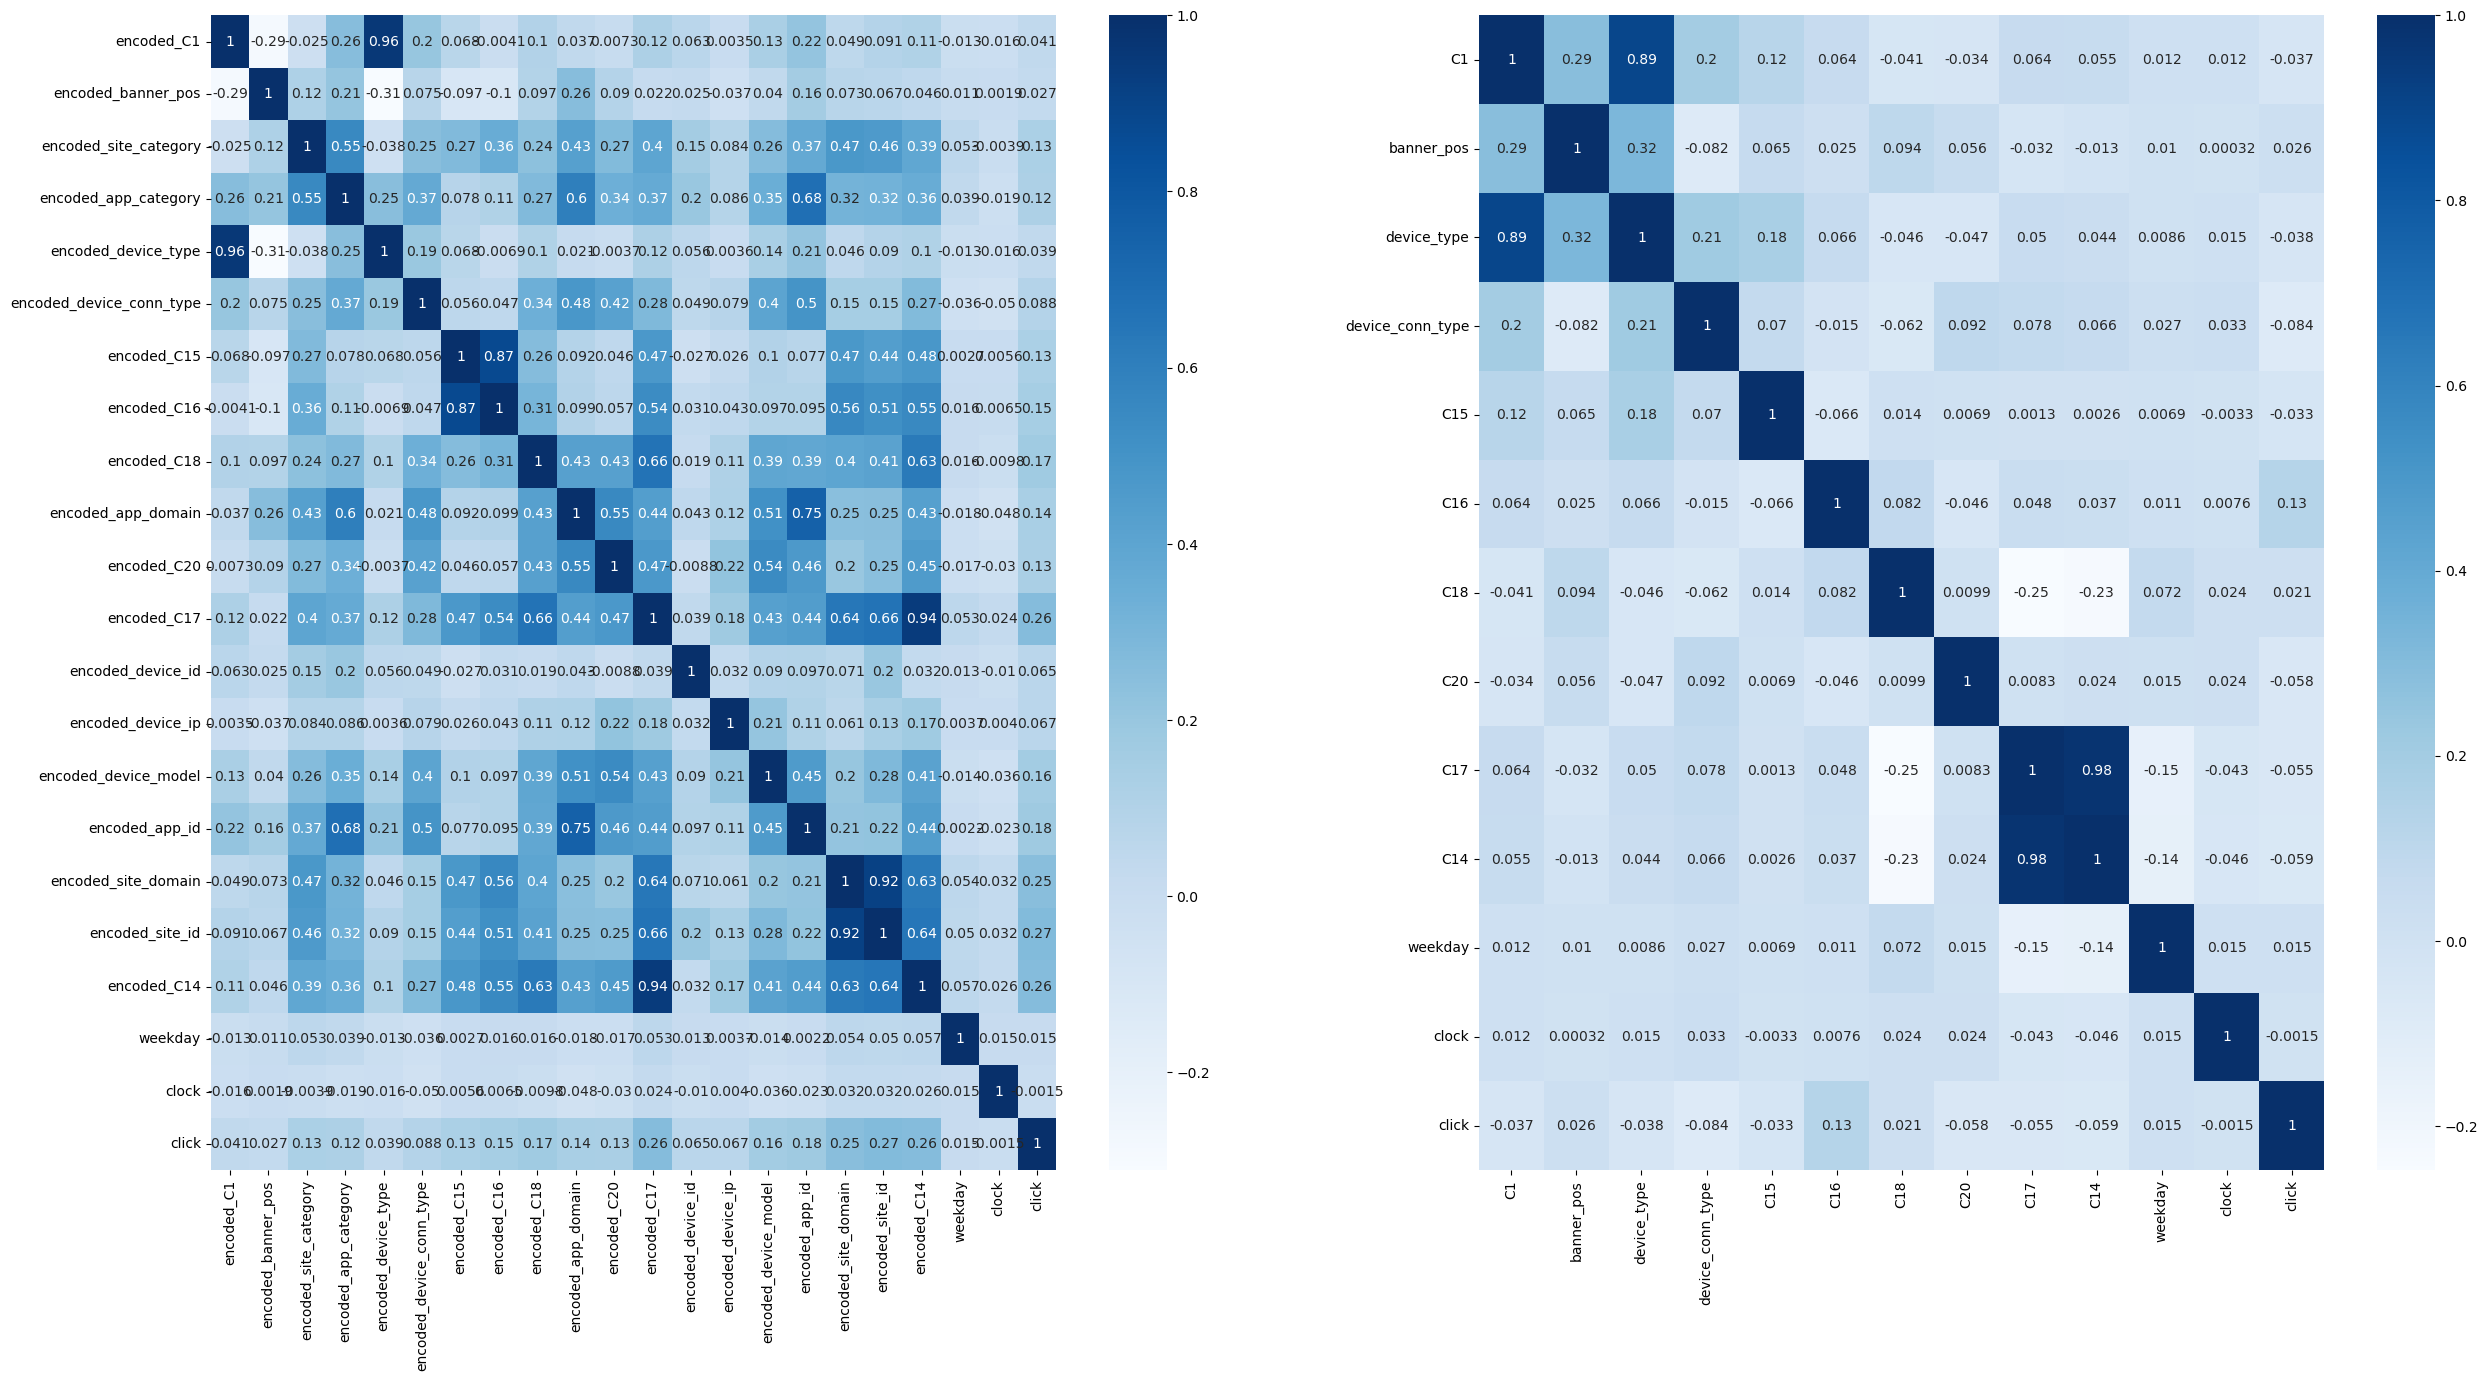

In [536]:
X_correlation = X.copy()
to_encode = easy_cols + medium_cols + hard_cols
to_encode.remove('hour')
for col in to_encode:
    count_encode(X_correlation, col, y)

col = X_correlation.pop('weekday')
X_correlation = pd.concat((X_correlation, col), axis=1)
col = X_correlation.pop('clock')
X_correlation = pd.concat((X_correlation, col), axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))

corr = (pd.concat((X_correlation, y), axis = 1)).corr()
hm = sns.heatmap(corr, cmap="Blues", annot=True, ax=axes[0])
ticks = np.arange(corr.shape[0]) + 0.5

corr = (pd.concat((X, y), axis = 1)).corr()
hm = sns.heatmap(corr, cmap="Blues", annot=True, ax=axes[1])
ticks = np.arange(corr.shape[0]) + 0.5

From the correlation table, we are interested in two relationships: C14 & C17; and site_id & site_ip.

From the correlation table to the left, we observe that C14 and C17 have very similar relatiopnship (i.e., correlation) with every other variable, so these are very similar. We can drop either of them.

In [569]:
X[['site_domain', 'site_id']].groupby('site_id').value_counts().unstack().count()

site_domain
005b495a    46
0064e9b7     1
006effce     1
00847768     2
00863f59     1
            ..
ffb2d478     1
ffc492ad     1
ffde5f3b     1
fff32e94     2
fff602a2     1
Length: 2871, dtype: int64

Indeed these values are correlated but given there are still many possible combinations of id and ip, even if only a small fraction, we still might want the two degrees of freedom, so we will not merge them in a new category. This concludes our data exploration :).

# Picking the best data

Now we are left with two questions: to merge or not to merge? And what is the best encoding for each feature: correlation, target, or count?

To try to answer this, we will perform our two model cross validation on two datasets. 


## .1 First Idea

The first one will consits in no dropped or merged columns. For this data set, we will mix correlation encode for the easy cols, target encode for the medium columns, and count encode for the hard columns. These encodings proved to be the most effective during the exploration phase.

In [15]:
easy_1 = ["C1", "banner_pos", "site_category", "app_category", "device_type", "device_conn_type", "C15", "C16", "C18"]
medium_1 = ["app_domain", "C20", "C17"]
hard_1 = ["device_id", "device_ip", "device_model", "app_id", "site_domain", "site_id", "C14"]
hour = ["weekday", "clock"]

In [16]:
all_cols = easy_1 + medium_1 + hard_1 + ['hour'] #this list will be useful in cells below

In [609]:
X_1 = df[all_cols].copy()
y = df['click'].copy()

In [610]:
X_1['weekday'] = X_1['hour'].apply(lambda x:datesplit(x).weekday())
X_1['clock'] = X_1['hour'].apply(lambda x:datesplit(x).hour)
X_1.drop('hour', inplace = True, axis = 1)

In [614]:
values = np.zeros(6)
for train_index, test_index in kf.split(X_1):
    X_train, X_test = X_1.iloc[train_index].copy(), X_1.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    for col in easy_1:
        encoder = correlation_encode(X_train, col, y_train)
        correlation_encode_transform(X_test, col, encoder)
        
    for col in medium_1:
        encoder = target_encode(X_train, col, y_train)
        target_encode_transform(X_test, col, encoder)
        
    for col in hard_1:
        encoder = count_encode(X_train, col, y_train)
        count_encode_transform(X_test, col, encoder)
        
    instance = two_models(X_train, X_test, y_train, y_test, verbose=False, return_feats=True)
    values = values + instance
        
values = values/5
print("\nAvg LR Accuracy = ", values[0])
print("Avg LR Log loss = ", values[1])
print("Avg Execution   = ", values[2])
print("\nAvg XGB Accuracy = ", values[3])
print("Avg XGB Log loss = ", values[4])
print("Avg Execution    = ", values[5])


Avg LR Accuracy =  0.8337399999999999
Avg LR Log loss =  0.40728526831654754
Avg Execution   =  34.63265500068665

Avg XGB Accuracy =  0.8348889999999999
Avg XGB Log loss =  0.3974507816129284
Avg Execution    =  28.210005235671996


## .2 Second idea

The second idea will consists in the merging and dropping of the few columns we saw before. We will taget encode the the easy cols and medium cols, and count encode the hard columns.

In [17]:
easy_2 = ["banner_pos", "category", "device_type", "device_conn_type", "C40", "C18"]
medium_2 = ["app_domain", "C20"]
hard_2 = ["device_id", "device_ip", "device_model", "app_id", "site_domain", "site_id", "C14"]
hour = ["weekday", "clock"]

In [18]:
X_2 = df[all_cols].copy()
y = df['click'].copy()

X_2['weekday'] = X_2['hour'].apply(lambda x:datesplit(x).weekday())
X_2['clock'] = X_2['hour'].apply(lambda x:datesplit(x).hour)
X_2.drop('hour', inplace = True, axis = 1)

X_2['C40'] = X_2['C15'] * X_2['C16']
X_2['category'] = X_2['app_category'] + X_2['site_category']
X_2.drop(columns=['app_category', 'site_category','C15', 'C16', 'C1', 'C17'], inplace = True, axis = 1)

In [628]:
values = np.zeros(6)
for train_index, test_index in kf.split(X_2):
    X_train, X_test = X_2.iloc[train_index].copy(), X_2.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    for col in easy_2 + medium_2:
        encoder = correlation_encode(X_train, col, y_train)
        correlation_encode_transform(X_test, col, encoder)
        
    for col in hard_2:
        encoder = count_encode(X_train, col, y_train)
        count_encode_transform(X_test, col, encoder)
        
    instance = two_models(X_train, X_test, y_train, y_test, verbose=False, return_feats=True)
    values = values + instance
        
values = values/5
print("\nAvg LR Accuracy = ", values[0])
print("Avg LR Log loss = ", values[1])
print("Avg Execution   = ", values[2])
print("\nAvg XGB Accuracy = ", values[3])
print("Avg XGB Log loss = ", values[4])
print("Avg Execution    = ", values[5])


Avg LR Accuracy =  0.8336270000000001
Avg LR Log loss =  0.4080061789749549
Avg Execution   =  91.91556997299195

Avg XGB Accuracy =  0.8349230000000001
Avg XGB Log loss =  0.39776795117506675
Avg Execution    =  27.375371074676515


Gine that the metrics are very similar, we will go with our simplest model. Meaning the one that has the least amount of features. That finilizes our feature engineering.

The conclusions of this part of the lab can be summarized in the next two functions.

In [150]:
def data_processing(df):
    X = df[all_cols].copy()
    y = df['click'].copy()
    
    # get weekday and clock data
    X['weekday'] = X['hour'].apply(lambda x:datesplit(x).weekday())
    X['clock'] = X['hour'].apply(lambda x:datesplit(x).hour)
    X.drop('hour', inplace = True, axis = 1)
    
    # merge variables
    X['C40'] = X['C15'] * X['C16']
    X['category'] = X['app_category'] + X['site_category']
    
    # drop the useless columns
    X.drop(columns=['app_category', 'site_category','C15', 'C16', 'C1', 'C17'], inplace = True, axis = 1)
    return X, y

In [159]:
def encoding(X_train, X_test, y_train, y_test, ):
    
    target_encoders = []
    #target encoding
    for col in easy_2 + medium_2:
        encoder = correlation_encode(X_train, col, y_train)
        correlation_encode_transform(X_test, col, encoder)
        target_encoders.append(encoder)
        
    count_encoders = []
    #count encoding
    for col in hard_2:
        encoder = count_encode(X_train, col, y_train)
        count_encode_transform(X_test, col, encoder)
        count_encoders.append(encoder)
        
    return X_train, X_test, y_train, y_test, target_encoders, count_encoders

# A tale of four models and one ensemble

We will work out four different models: Logistic Regression, XGBoost, Random Forest, and a Multilayer Preceptron, and we will finally ensemble them all into a single model (by averaging their predictions). But first we need to prepare our data.

In [160]:
X, y = data_processing(df)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size = 0.8) # train test split
X_train, X_test, y_train, y_test, target_encoders, count_encoders = encoding(X_train, X_test, y_train, y_test) # encode according to our conclusions

## .1 Random Forest Fine Tuning

`n_estimators`: The number of trees in the forest. Default value = 100

`max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Deafaul value = `None`. We wont test the None parameter as it tends to overfit the data. Instead, we put a cap on 25. Should the optimal `max_depth = 25` we might explore the depth `None`

In [645]:
from sklearn.ensemble import RandomForestClassifier

rfPipe = Pipeline( [ ('classifier', RandomForestClassifier())])

params =   {'classifier__n_estimators': [20, 100, 200], 
            'classifier__max_depth': [5, 12, 25],
           }

cross_rf = GridSearchCV(rfPipe, params, cv=2, scoring='neg_log_loss')
cross_rf.fit(X_train, y_train)

log_loss(y_test, cross_rf.best_estimator_.predict_proba(X_test))

0.399741408854358

In [648]:
best_rf = cross_rf.best_estimator_
print(best_rf)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=12, n_estimators=200))])


Since our max depth was clearly an important factor of our random forest, we are now suspicious that we might be able to control more than the max depth to prevent the overfiting and improve classification. Additionally, we test increasing the components.

`min_samples_leaf`: The minimum number of samples required to be at a leaf node. Default value = 1

We do not test `min_samples_split` because the other two parameters already control the trees' sizes enough.

In [670]:
rfPipe = Pipeline( [ ('classifier', RandomForestClassifier())])

params =   {'classifier__n_estimators': [200, 300], 
            'classifier__max_depth': [8, 12, 16],
            'classifier__min_samples_leaf': [1, 5, 20]
           }

cross_rf = GridSearchCV(rfPipe, params, cv=2, scoring='neg_log_loss')
cross_rf.fit(X_train, y_train)

log_loss(y_test, cross_rf.best_estimator_.predict_proba(X_test))

0.3975111578171865

In [671]:
best_rf = cross_rf.best_estimator_
print(best_rf)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=16, min_samples_leaf=5,
                                        n_estimators=300))])


## .2 Logistic Regression Fine Tuning

Now, our logistic regression.

`C` = nverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

`tol` = Tolerance for stopping criteria.

`class_weight` = Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

In [651]:
lrPipe = Pipeline( [ ('classifier', LogisticRegression(max_iter = 1000000, solver='saga') ) ])

params =   {'classifier__C': [0.1, 0.5, 1.0], 
            'classifier__tol': [1e-4, 1e-3],
            'classifier__class_weight': [None, 'balanced']}

cross_lr = GridSearchCV(lrPipe, params, cv=2, scoring='neg_log_loss', verbose = 1.5)
cross_lr.fit(X_train, y_train)

log_loss(y_test, cross_lr.best_estimator_.predict_proba(X_test))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__tol=0.0001; total time= 2.6min
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__tol=0.0001; total time= 2.9min
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__tol=0.001; total time= 1.1min
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__tol=0.001; total time= 1.1min
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__tol=0.0001; total time= 2.1min
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__tol=0.0001; total time= 2.1min
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__tol=0.001; total time=  58.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__tol=0.001; total time= 1.2min
[CV] END classifier__C=0.5, classifier__class_weight=None, classifier__tol=0.0001; total time= 3.7min
[CV] END 

0.40809570268122664

In [654]:
best_lr = cross_lr.best_estimator_
print(cross_lr.best_estimator_)

Pipeline(steps=[('classifier',
                 LogisticRegression(max_iter=1000000, solver='saga'))])


## .3 XGBoost Fine Tuning


Now our XGBoost

`eta` = Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. Devault value = 0.3

`Gamma` = Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. Default value = 0

We also want to explore `max_depth`. However, XGBoost documentation warns, *beware that XGBoost aggressively consumes memory when training a deep tree*. Since we don't want to overload our mac, we split the pipeline into two, one that explore the first two paramenters, and then the max depth

In [663]:
xgPipe = Pipeline( [ ('classifier', XGBClassifier())])

params =   {'classifier__eta': [0.1, 0.3, 0.8], 
            'classifier__gamma': [0, 1, 2],
           }

cross_xg = GridSearchCV(xgPipe, params, cv=2, scoring='neg_log_loss')
cross_xg.fit(X_train, y_train)

log_loss(y_test, cross_xg.best_estimator_.predict_proba(X_test))

0.39803066440309964

In [664]:
best_xg = cross_xg.best_estimator_
print(best_xg)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.3,
                               eval_metric=None, feature_types=None, gamma=0,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
        

`eta = 0.3` and `gamma = 0`

In [667]:
xgPipe = Pipeline( [ ('classifier', XGBClassifier())])

params =   {'classifier__eta': [0.3], 
            'classifier__gamma': [0],
            'classifier__max_depth': [3, 5, 6, 7]
           }

cross_xg = GridSearchCV(xgPipe, params, cv=2, scoring='neg_log_loss')
cross_xg.fit(X_train, y_train)

log_loss(y_test, cross_xg.best_estimator_.predict_proba(X_test))

0.39803066440309964

In [662]:
best_xg = cross_xg.best_estimator_
print(best_xg)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.3,
                               eval_metric=None, feature_types=None, gamma=0,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
           

Default parameters are the best.

## .4 Training a multilayer perceptron

We train a multilayer perceptron with two hidden layers of dimension 35. Nothing particularly special about this value 35. Not shown here, a number of hidden dimensions 5 and 15 have been attempted. No performance improvement. 

In [141]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
from torch.optim import Adam, SGD
import torch.optim as optim
from torch.nn.functional import nll_loss, cross_entropy
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F


input_dim_mlp = 17

# number of hidden layers dimension
hidden_dim_mlp = 35

# number of classes
output_dim_mlp = 2


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim_mlp, hidden_dim_mlp)
        self.linear2 = nn.Linear(hidden_dim_mlp, output_dim_mlp)

    def forward(self, x):
        h_relu = nn.ReLU()
        flattened = x.view(-1, input_dim_mlp)
        hidden = self.linear1(flattened)
        activated = h_relu(hidden)
        y_pred = self.linear2(activated)
        return y_pred

In [ ]:
mlp = MLP()
mlp.to(device)
# Optimizer
epochs = 10#
learning_rate = 1e-4
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

In [64]:
# Check if CUDA is available when testing in google colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define batch size
batch_size = 32

X_train_tensor = torch.Tensor(X_train.values)
y_train_tensor = torch.Tensor(y_train.values).type(torch.LongTensor)
X_test_tensor = torch.Tensor(X_test.values)
y_test_tensor = torch.Tensor(y_test.values).type(torch.LongTensor)

# Normalize the data
mean = torch.mean(X_train_tensor, dim=0)
std = torch.std(X_train_tensor, dim=0)
X_train_tensor = (X_train_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# Move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Create the dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Create TensorDataset objects for train and test data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects for train and test data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

cpu


In [65]:
losses = []
for t in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()
        
        # Feed forward
        outputs = mlp.forward(inputs)
        
        #loss
        loss = criterion(outputs, labels)
        
        # backward propagation
        loss.backward()
        # One optimization step
        optimizer.step()
        
        losses.append(loss.item())
        
        if not i % 12000:
            print(t, i, loss.item())


0 0 0.8552818298339844
0 12000 0.43796980381011963
0 24000 0.5649849772453308
1 0 0.3688773810863495
1 12000 0.35953283309936523
1 24000 0.39652565121650696
2 0 0.277587354183197
2 12000 0.3002096712589264
2 24000 0.3315173387527466
3 0 0.4619090259075165
3 12000 0.5782681703567505
3 24000 0.2671670913696289
4 0 0.3827998638153076
4 12000 0.4593515992164612
4 24000 0.45552822947502136
5 0 0.4480590224266052
5 12000 0.28920555114746094
5 24000 0.3657401502132416
6 0 0.4167361855506897
6 12000 0.42603063583374023
6 24000 0.47019580006599426
7 0 0.4313367009162903
7 12000 0.4533512592315674
7 24000 0.3415850102901459
8 0 0.22079569101333618
8 12000 0.20517948269844055
8 24000 0.3596067726612091
9 0 0.5611088871955872
9 12000 0.3009375333786011
9 24000 0.4630942642688751


In [78]:
size_test = X_test_tensor.data.shape[0]
correct = 0
for data in testloader:
    inputs, labels = data
    outputs = mlp.forward(inputs)
    predicted = torch.argmax(outputs, dim=1)
    correct += (predicted == labels).sum()

    
final_accuracy = correct/size_test

print('Acuracy of the perceptron =', float(final_accuracy))

Acuracy of the perceptron 0.8336099982261658


In [123]:
output_tensor = mlp.forward(X_test_tensor).cpu().detach().numpy()
perceptron_predictions = F.softmax(torch.tensor(output_tensor), dim=1)
print('Log_loss of the perceptron', log_loss(y_test, perceptron_predictions))

Log_loss of the perceptron 0.40365097390535754


## .5 Ensambling

For the final part of this lab, we ensemble the 4 models. We check which ensemble combination is the most optimal.

In [70]:
#we had to train the neural network on a separate intance of this notebook
# and our internal variables resetted, so we refit our models with the best 
# parameter we have found.
best_lr = LogisticRegression(max_iter = 100000)
best_rf = RandomForestClassifier(max_depth=16, min_samples_leaf=5, n_estimators=300)
best_xg = XGBClassifier()

In [ ]:
best_lr.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_xg.fit(X_train, y_train)

In [135]:
lr_pred = best_lr.predict_proba(X_test)
rf_pred = best_rf.predict_proba(X_test)
xg_pred = best_xg.predict_proba(X_test)
mp_pred = np.array(perceptron_predictions)

In [136]:
print("Every log loss so far:")
print("Logistic regression =", log_loss(y_test,  lr_pred))
print("Random Forest Class =", log_loss(y_test,  rf_pred))
print("XGBoost Classifier  =", log_loss(y_test,  xg_pred))
print("Multilayer Percept  =", log_loss(y_test,  mp_pred))

print('\nEvery accuracy so far:')
print("Logistic regression =", accuracy_score(y_test,  lr_pred[:, 1] > 0.5))
print("Random Forest Class =", accuracy_score(y_test,  rf_pred[:, 1] > 0.5))
print("XGBoost Classifier  =", accuracy_score(y_test,  xg_pred[:, 1] > 0.5))
print("Multilayer Percept  =", accuracy_score(y_test,  mp_pred[:, 1] > 0.5))

Every log loss so far:
Logistic regression = 0.4074861061926959
Random Forest Class = 0.3971596685833206
XGBoost Classifier  = 0.39790932215637936
Multilayer Percept  = 0.40365097390535754

Every accuracy so far:
Logistic regression = 0.833365
Random Forest Class = 0.834635
XGBoost Classifier  = 0.834615
Multilayer Percept  = 0.83361


We ensemble all our models now, taking the average

In [139]:
ensemble_pred = (lr_pred + rf_pred + xg_pred + mp_pred )/4
print("All Ensemble log loss = ", log_loss(y_test,  ensemble_pred))
print("All ensemble accuracy = ", accuracy_score(y_test, ensemble_pred[:, 1] > 0.5))

All Ensemble log loss =  0.39953463475107465
All ensemble accruacy =  0.83426


We do not improve on our performance of the best model. 
And finally, if we ensemble our two best performing models

In [143]:
ensemble_pred = (rf_pred + xg_pred )/2
print("Tree based Ensemble = ", log_loss(y_test,  ensemble_pred))
print("Tree based accuracy = ", accuracy_score(y_test, ensemble_pred[:, 1] > 0.5))

Tree based Ensemble =  0.3969151686520218
Tree based accuracy =  0.834745


We improve the performance from our best original model (random  forest)!

We have finalized the model selection.

# Kaggle submission

In [144]:
!gzip -d test.gz

In [145]:
!pwd

/Users/guevara/Downloads


In [222]:
kaggle = pd.read_csv('test', dtype={"id": "string"})

In [224]:
def data_processing_2(df):
    X = df[all_cols].copy()
    
    # get weekday and clock data
    X['weekday'] = X['hour'].apply(lambda x:datesplit(x).weekday())
    X['clock'] = X['hour'].apply(lambda x:datesplit(x).hour)
    X.drop('hour', inplace = True, axis = 1)
    
    # merge variables
    X['C40'] = X['C15'] * X['C16']
    X['category'] = X['app_category'] + X['site_category']
    
    # drop the useless columns
    X.drop(columns=['app_category', 'site_category','C15', 'C16', 'C1', 'C17'], inplace = True, axis = 1)
    return X

kaggle_p = data_processing_2(kaggle)

In [225]:
def encoding_2(X_test, target_encoders, count_encoders):
    #target encoding
    for col, encoder in zip(easy_2 + medium_2, target_encoders):
        correlation_encode_transform(X_test, col, encoder)
        
    #count encoding
    for col, encoder in zip(hard_2, count_encoders):
        count_encode_transform(X_test, col, encoder)
        
    return X_test

kaggle_f = encoding_2(kaggle_p, target_encoders, count_encoders)

We prepare two submissions. One with our tree based ensemble (XG boost + random forest)

In [226]:
submission = pd.DataFrame()

In [227]:
submission['id'] = kaggle['id']

In [229]:
sub_probas = (best_rf.predict_proba(kaggle_f)[:,1] + best_xg.predict_proba(kaggle_f)[:,1])/2

In [230]:
submission['click'] = sub_probas

In [232]:
submission.to_csv('submission.csv', index = False)

And another one with all the models ensembled

In [251]:
kaggle_f_tensor = torch.Tensor(kaggle_f.values).clone()
output_tensor = mlp.forward(kaggle_f_tensor).detach()

perceptron_predictions = np.array(F.softmax(output_tensor, dim=1))

sub_probas_2 = (sub_probas + best_lr.predict_proba(kaggle_f)[:, 1] + perceptron_predictions[:, 1])/2

In [244]:
submission['click'] = sub_probas_2
submission.to_csv('submission2.csv', index = False)

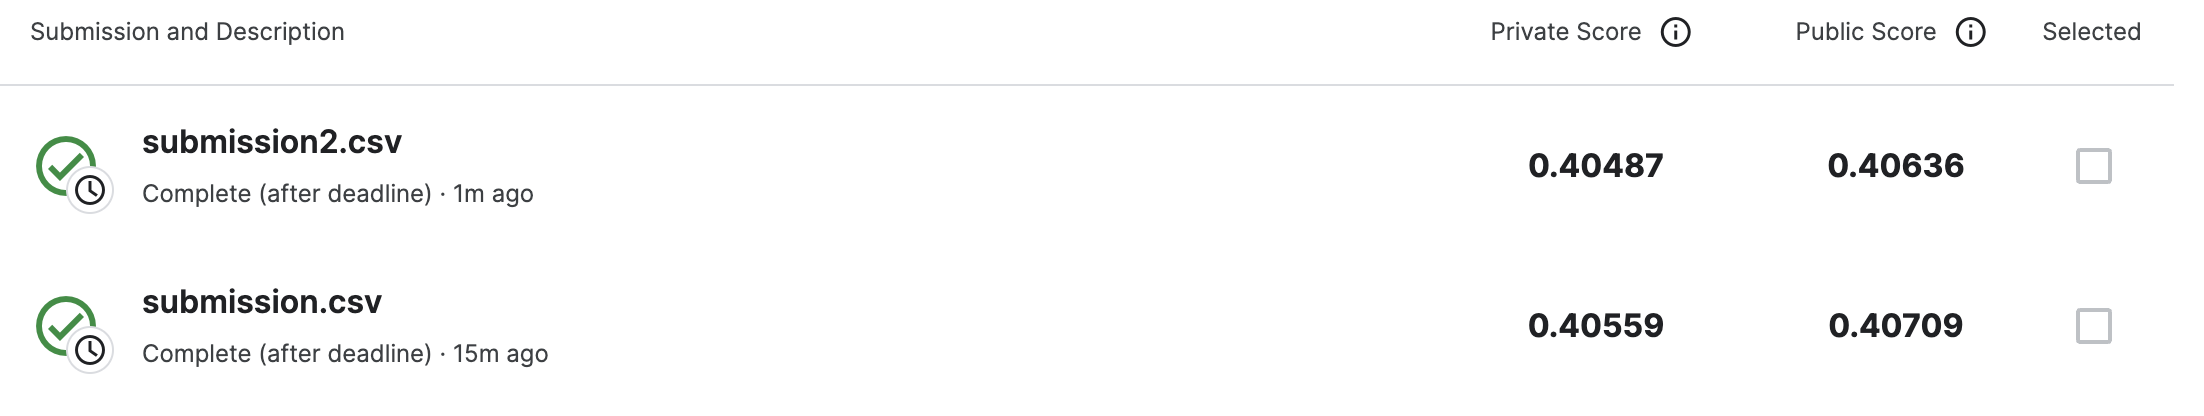

We could not get that sub 0.40 but we definitely tried our best :)

There are a few ideas that were not explored during the lab:

* We did not performed PCA on the data. This might have reduced noisiness. It would interesting to see the performance of models with uncorrelated data after encoding.

* We did not generate additional features from trees, as in a factorization machine.

* We did not resampled the data to have a balanced classification problem. 

* We did not take into consideration C21 (by mistake :( )

